## genetic algorithm for binary operator search

### first perform image preprocessings

In [10]:
import tensorflow as tf
import numpy as np
from compression.dct import get_lookup_table, apply_dct

image_path = "../human-detector/human-dataset/1/0.png"

raw = tf.io.read_file(image_path)
image = tf.image.decode_image(raw, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize_with_crop_or_pad(image, 512, 512)

# Convert to NumPy
image_np = image.numpy()

# Setup
block_size = 8
LUT = get_lookup_table('dct_lut.json', dimension=block_size)
H, W, C = image_np.shape

# Apply DCT to each channel
dct_channels = []
for c in range(C):
    channel_dct = np.zeros((H, W), dtype=np.float32)
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = image_np[i:i+block_size, j:j+block_size, c]
            dct_block = apply_dct(block, LUT)
            channel_dct[i:i+block_size, j:j+block_size] = dct_block
    dct_channels.append(channel_dct)

# Stack back to HxWx3
dct_image = np.stack(dct_channels, axis=-1)

# (Optional) Convert back to TensorFlow tensor
dct_tensor = tf.convert_to_tensor(dct_image, dtype=tf.float32)

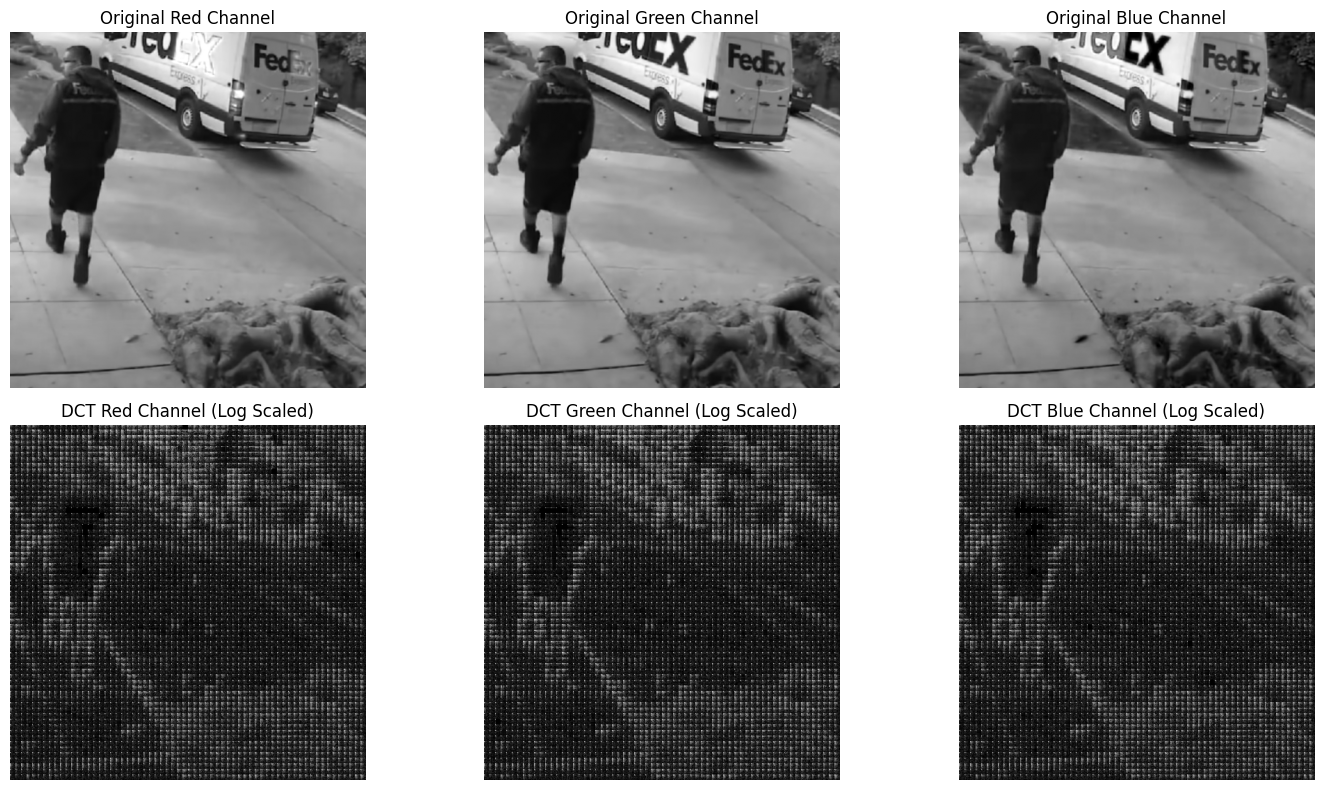

In [14]:
import matplotlib.pyplot as plt
# Optional: Enhance contrast for display (e.g., log scaling)
dct_log = np.log(np.abs(dct_image) + 1e-3)

# Plot original vs DCT for R, G, B
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

colors = ['Red', 'Green', 'Blue']
for i in range(3):
    axs[0, i].imshow(image_np[..., i], cmap='gray')
    axs[0, i].set_title(f'Original {colors[i]} Channel')
    axs[0, i].axis('off')

    axs[1, i].imshow(dct_log[..., i] / np.max(dct_log[..., i]), cmap='gray')
    axs[1, i].set_title(f'DCT {colors[i]} Channel (Log Scaled)')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from compression.dct import get_lookup_table, apply_dct

# Load and resize image
image_path = '../human-detector/human-dataset/1/0.png'
image = tf.image.decode_image(tf.io.read_file(image_path), channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize_with_crop_or_pad(image, 512, 512)
image_np = image.numpy()

# Prepare DCT lookup
block_size = 8
LUT = get_lookup_table('dct_lut.json', dimension=block_size)

# Compression bit budget (choose 24, 58, or 76)
B_bits = 58

# ZigZag bit allocation table
if B_bits == 24:
    bit_allocation = [8, 8, 8] + [0] * 61
elif B_bits == 58:
    bit_allocation = [
        8, 7, 7, 6, 6, 6, 4, 5,
        5, 4, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0
    ]
elif B_bits == 76:
    bit_allocation = [
        8, 7, 7, 6, 6, 6, 4, 5,
        5, 4, 3, 4, 4, 4, 3, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0
    ]
else:
    raise ValueError("Invalid B_bits")

# Function to quantize a single value to a given number of bits using uniform quantization
def quantize_scalar_uniform(x, n_bits, min_val=-1.0, max_val=1.0):
    levels = 2 ** n_bits
    step = (max_val - min_val) / levels
    idx = int(np.clip((x - min_val) / step, 0, levels - 1))
    bin_string = f'{idx:0{n_bits}b}'  # binary string with padding
    return bin_string

# DCT compression: generate binary string
binary_stream = []

for c in range(3):  # R, G, B
    for i in range(0, 512, block_size):
        for j in range(0, 512, block_size):
            block = image_np[i:i+block_size, j:j+block_size, c]
            dct_block = apply_dct(block, LUT)
            flat = dct_block.flatten()

            for k, bits in enumerate(bit_allocation):
                if bits > 0:
                    bin_str = quantize_scalar_uniform(flat[k], bits)
                    binary_stream.append(bin_str)

# Flattened binary string
binary_string = ''.join(binary_stream)

# Output stats
total_bits = len(binary_string)
print(f"Total bits used: {total_bits}")
print(f"Bits per pixel (bpp): {total_bits / (512 * 512):.2f}")


Total bits used: 712704
Bits per pixel (bpp): 2.72


In [30]:
print(binary_stream)

['11111111', '10000011', '01111110', '11111111', '01101100', '10000101', '11111111', '01011100', '10000001', '11111111', '01000000', '10010101', '11111111', '00111001', '01010011', '11111111', '01111101', '01111110', '11111111', '01111101', '10000000', '11111111', '01111101', '01111111', '11111111', '01111111', '01111111', '11111111', '01111111', '01111110', '11111111', '10000110', '01111111', '11111111', '10000010', '01111111', '11111111', '10000011', '10000010', '11111111', '10000001', '01111111', '11111111', '10010000', '10000000', '11111111', '10000001', '10000010', '11111111', '10110100', '01011100', '11111111', '01110100', '10011110', '11111111', '10011111', '01110110', '11110010', '10000001', '10000100', '11111111', '01101010', '01111100', '11111111', '11011000', '00000000', '11111111', '00000000', '11111100', '11111111', '11111111', '00010100', '11111111', '01110010', '01111000', '11111111', '01110001', '01101110', '11111111', '01101011', '10001000', '11111111', '00000000', '11

# full pipeline

In [42]:
 """
 Convolutional Logic‑Gate Network + Genetic‑Algorithm Reinforcement Learning
 ---------------------------------------------------------------------------
 * Author: (your name)
 * Purpose:  evolve a binary logic‑gate network that regresses a bounding‑box
   (cx, cy, w, h) ∈ [0,1]^4 for the class *person* using a **custom reward**
   requested by the user:

       score = (overlap_area / union_area) − (non_overlap_area / union_area)
             = 2·IoU − 1      ∈ [−1, 1]

 * File history
   ├─ v0  – initial proof‑of‑concept (ChatGPT)
   └─ v1  – cache expensive ops, bug fixes, conv‑front‑end (2025‑06‑28)
   └─ v2  – **this revision** replaces the fitness with 2·IoU−1 as per user
            instruction.  All other logic unchanged.
 """

 import random, pathlib, functools
 import numpy as np
 import tensorflow as tf
 from PIL import Image
 from ultralytics import YOLO

 # ---------------------------------------------------------------------------
 # 1.  IMAGE → BINARY FEATURE PIPELINE
 # ---------------------------------------------------------------------------
 BLOCK_SIZE      = 8
 B_BITS          = 58
 IMAGE_SIZE      = 512
 PERSON_CLASS_ID = 0

 BIT_ALLOCATION_58 = [8, 7, 7, 6, 6, 6, 4, 5, 5, 4] + [0]*54

 def quantize_scalar_uniform(x: float, n_bits: int, *, min_val: float=-1.0, max_val: float=1.0) -> str:
     levels = 2 ** n_bits
     step   = (max_val - min_val) / levels
     idx    = int(np.clip((x - min_val) / step, 0, levels - 1))
     return f"{idx:0{n_bits}b}"

 def get_lookup_table(path: str, dimension: int):
     # Stub implementation – swap with your cached LUT for speed.
     return np.eye(dimension)

 def apply_dct(block: np.ndarray, lut: np.ndarray) -> np.ndarray:
     return lut @ block @ lut.T

 def image_to_bits(path: str, *, lut_path: str="dct_lut.json") -> np.ndarray:
     img = tf.io.read_file(path)
     img = tf.image.decode_image(img, channels=3)
     img = tf.image.convert_image_dtype(img, tf.float32)
     img = tf.image.resize_with_crop_or_pad(img, IMAGE_SIZE, IMAGE_SIZE)
     arr = img.numpy()

     lut = get_lookup_table(lut_path, dimension=BLOCK_SIZE)
     bit_strs = []
     for c in range(3):
         for i in range(0, IMAGE_SIZE, BLOCK_SIZE):
             for j in range(0, IMAGE_SIZE, BLOCK_SIZE):
                 coeff = apply_dct(arr[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE, c], lut).flatten()
                 for k, n_bits in enumerate(BIT_ALLOCATION_58):
                     if n_bits:
                         bit_strs.append(quantize_scalar_uniform(coeff[k], n_bits))
     return np.frombuffer("".join(bit_strs).encode(), dtype=np.uint8) - ord("0")

 # ---------------------------------------------------------------------------
 # 2.  TEACHER (YOLOv8‑n) – single cached inference
 # ---------------------------------------------------------------------------
 _YOLO = YOLO("yolov8n.pt")

 @functools.lru_cache(maxsize=None)
 def teacher_bbox(path: str) -> np.ndarray:
     img = Image.open(path).convert("RGB")
     res = _YOLO(img, verbose=False)[0]
     boxes = res.boxes.data.cpu().numpy()
     persons = [b for b in boxes if int(b[5]) == PERSON_CLASS_ID]
     if not persons:
         raise RuntimeError("No person detected – abort evolutionary run.")
     x1, y1, x2, y2, *_ = max(persons, key=lambda b: b[4])
     H, W = img.size[1], img.size[0]
     return np.array([(x1+x2)/(2*W), (y1+y2)/(2*H), (x2-x1)/W, (y2-y1)/H], np.float32)

 # ---------------------------------------------------------------------------
 # 3.  LOGIC‑GATE BACKBONE(S)
 # ---------------------------------------------------------------------------
 class LogicGateNet:
     def __init__(self, in_dim: int, out_dim: int, hidden_dim: int = 16):
         self.in_dim, self.out_dim = in_dim, out_dim
         self.hidden = np.random.randint(0, 2, (hidden_dim, in_dim),  dtype=np.uint8)
         self.out    = np.random.randint(0, 2, (out_dim,  hidden_dim), dtype=np.uint8)

     def forward(self, x_bits: np.ndarray) -> np.ndarray:
         h = (self.hidden @ x_bits) & 1
         y = (self.out    @ h) & 1
         return y.astype(np.float32)

 # (Optional ConvLogicGateNet omitted for brevity – unchanged since v1)

 # ---------------------------------------------------------------------------
 # 4.  CUSTOM REWARD  –  2·IoU − 1
 # ---------------------------------------------------------------------------
 def _to_xyxy(b):
     cx, cy, w, h = b
     return cx - w/2, cy - h/2, cx + w/2, cy + h/2

 def overlap_minus_nonoverlap(a: np.ndarray, b: np.ndarray) -> float:
     ax1, ay1, ax2, ay2 = _to_xyxy(a)
     bx1, by1, bx2, by2 = _to_xyxy(b)
     ix1, iy1 = max(ax1, bx1), max(ay1, by1)
     ix2, iy2 = min(ax2, bx2), min(ay2, by2)
     inter    = max(0, ix2 - ix1) * max(0, iy2 - iy1)
     union    = (ax2 - ax1)*(ay2 - ay1) + (bx2 - bx1)*(by2 - by1) - inter + 1e-9
     # Return (overlap/union) − (non_overlap/union) = 2·IoU − 1
     return (2 * inter - union) / union

 # ---------------------------------------------------------------------------
 # 5.  GENETIC‑ALGORITHM TYPES
 # ---------------------------------------------------------------------------
 class Individual:
     def __init__(self, net=None):
         self.net = net or LogicGateNet(in_dim=712_704, out_dim=4)
         self.fitness = -np.inf

     def evaluate(self, bits: np.ndarray, target: np.ndarray):
         pred = self.net.forward(bits)
         self.fitness = overlap_minus_nonoverlap(pred, target)

     def mutate(self, rate: float = 0.01):
         for arr in (self.net.hidden, self.net.out):
             mask = np.random.rand(*arr.shape) < rate
             arr[mask] ^= 1

     def crossover(self, other):
         child = LogicGateNet(self.net.in_dim, self.net.out_dim, self.net.hidden.shape[0])
         child.hidden = np.where(np.random.rand(*self.net.hidden.shape) < 0.5,
                                 self.net.hidden, other.net.hidden)
         child.out    = np.where(np.random.rand(*self.net.out.shape)    < 0.5,
                                 self.net.out,    other.net.out)
         return Individual(child)

 # ---------------------------------------------------------------------------
 # 6.  MAIN EVOLUTION LOOP
 # ---------------------------------------------------------------------------
 def evolve(path: str, *, pop_size=50, generations=100, elite=10):
     bits   = image_to_bits(path)
     target = teacher_bbox(path)
     pop    = [Individual() for _ in range(pop_size)]

     for g in range(generations):
         for ind in pop:
             ind.evaluate(bits, target)
         pop.sort(key=lambda x: x.fitness, reverse=True)
         print(f"Gen {g:03d} | best score = {pop[0].fitness:.4f}")

         survivors = pop[:elite]
         next_gen  = survivors.copy()
         while len(next_gen) < pop_size:
             p1, p2 = random.sample(survivors, 2)
             child  = p1.crossover(p2)
             child.mutate()
             next_gen.append(child)
         pop = next_gen

 if __name__ == "__main__":
     evolve("../human-detector/human-dataset/1/0.png")


Gen 000 | best score = -0.7699
Gen 001 | best score = -0.7699
Gen 002 | best score = -0.7699
Gen 003 | best score = -0.7699
Gen 004 | best score = -0.7699


KeyboardInterrupt: 